<a href="https://colab.research.google.com/github/minurasam/Brain-Tumor-Detection-CNN/blob/main/Assignment_4_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision.transforms import transforms
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from PIL import Image

In [2]:
train_transform = transforms.Compose([transforms.Resize((150,150)),
                                     transforms.RandomCrop(149),
                                     transforms.ToTensor(),
                                     transforms.RandomHorizontalFlip()])
test_transform = transforms.Compose([transforms.Resize((150,150)),

                                     transforms.ToTensor()
                                     ])

In [3]:
train_image = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Research Experiments/train",transform =train_transform )
test_image = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Research Experiments/test", transform = test_transform)

In [ ]:
img = Image.open('/content/drive/MyDrive/Research Experiments/test/')

In [4]:
train_loader = torch.utils.data.DataLoader(train_image,shuffle = True,batch_size = 32)
test_loader = torch.utils.data.DataLoader(test_image,shuffle = False, batch_size = 32)

In [5]:
class ConvNet(nn.Module):
    def __init__(self,output_class):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,out_channels = 16,kernel_size = 2)
        self.drop1 = nn.Dropout(0.2)
        self.rel1  = nn.ReLU()
        self.maxP  = nn.MaxPool2d(kernel_size = 4)
        self.conv2 = nn.Conv2d(in_channels = 16,out_channels = 16,kernel_size = 2 )
        self.drop2 = nn.Dropout(0.2)
        self.rel2 = nn.ReLU()
        self.maxP2 = nn.MaxPool2d(kernel_size = 4)
        self.fc1 = nn.Linear(in_features = 9*9*16, out_features =128 )
        self.fc2 = nn.Linear(in_features =128,out_features = output_class)

    def forward(self,input):
        x = self.conv1(input)
        x = self.drop1(x)
        x = self.rel1(x)
        x = self.maxP(x)

        x = self.conv2(x)
        x = self.drop2(x)
        x = self.rel1(x)
        x = self.maxP2(x)
        x = x.view(-1,16*9*9)
        x = self.fc1(x)
        x = self.fc2(x)


        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
epoch = 10
model = ConvNet(2).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [23]:
epoch = 20
model = ConvNet(2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

best_validation_loss = float('inf')
patience = 3  # Number of epochs with no improvement after which training will be stopped

for epochs in range(epoch):
    train_loss = 0
    test_loss = 0
    correct_predictions = 0
    total_samples = 0

    model.train()

    for img, label in train_loader:
        img, label = img.to(device), label.to(device)

        output = model(img)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * img.size(0)

    model.eval()
    with torch.no_grad():
        for test_img, test_label in test_loader:
            test_img, test_label = test_img.to(device), test_label.to(device)
            test_output = model(test_img)

            testing_loss = criterion(test_output, test_label)
            test_loss += testing_loss.item() * test_img.size(0)

            _, pred = torch.max(test_output, 1)
            correct_predictions += torch.sum(pred == test_label.data)
            total_samples += test_label.size(0)

    accuracy = correct_predictions.item() / total_samples * 100
    average_validation_loss = test_loss / len(test_image)

    print(f"Epoch: {epochs}/{epoch}, Train Loss: {train_loss / len(train_image)}, "
          f"Test Loss: {average_validation_loss}, Accuracy: {accuracy}%")

    # Stopping criteria
    if average_validation_loss < best_validation_loss:
        best_validation_loss = average_validation_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping. No improvement in validation loss.")
            break


Epoch: 0/20, Train Loss: 0.7349249664474936, Test Loss: 0.6578294356664022, Accuracy: 56.666666666666664%
Epoch: 1/20, Train Loss: 0.583725002933951, Test Loss: 0.5533929626146953, Accuracy: 81.66666666666667%
Epoch: 2/20, Train Loss: 0.45501897159744714, Test Loss: 0.4040473123391469, Accuracy: 90.0%
Epoch: 3/20, Train Loss: 0.3459184139966965, Test Loss: 0.28828087250391643, Accuracy: 95.0%
Epoch: 4/20, Train Loss: 0.28983373045921323, Test Loss: 0.22647047638893128, Accuracy: 95.0%
Epoch: 5/20, Train Loss: 0.24165311964119182, Test Loss: 0.23247035046418507, Accuracy: 91.66666666666666%
Epoch: 6/20, Train Loss: 0.18096627733286688, Test Loss: 0.1638076941172282, Accuracy: 96.66666666666667%
Epoch: 7/20, Train Loss: 0.15609318859436933, Test Loss: 0.13828339278697968, Accuracy: 95.0%
Epoch: 8/20, Train Loss: 0.13016377003753887, Test Loss: 0.12763622576991718, Accuracy: 96.66666666666667%
Epoch: 9/20, Train Loss: 0.10078237407347736, Test Loss: 0.09324352741241455, Accuracy: 98.33333

In [28]:
random_image_tester = ["/content/drive/MyDrive/Research Experiments/test/cocacola/0.jpg","/content/drive/MyDrive/Research Experiments/test/cocacola/12.jpg","/content/drive/MyDrive/Research Experiments/test/pepsi/12.jpg","/content/drive/MyDrive/Research Experiments/test/pepsi/21.jpg"]
image_pil_transform = [Image.open(a) for a in random_image_tester]
image_trans_transform = [test_transform(a) for a in image_pil_transform]
image_stack_transform = torch.stack([test_transform(a) for a in image_pil_transform])

In [29]:
model = model.to("cpu")
for g,i in enumerate(image_stack_transform):
    output = model(i)
    idx = torch.argmax(output)
    name = ["cola","cola","pepsi","pepsi"]
    out = test_image.classes
    print("pred: ",out[idx]," ","real: ",name[g])

pred:  cocacola   real:  cola
pred:  cocacola   real:  cola
pred:  pepsi   real:  pepsi
pred:  pepsi   real:  pepsi


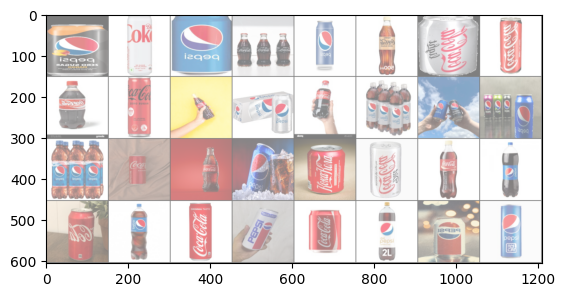

pepsi cocacola pepsi cocacola pepsi cocacola cocacola cocacola cocacola cocacola cocacola pepsi cocacola pepsi pepsi pepsi pepsi cocacola cocacola pepsi cocacola cocacola cocacola pepsi cocacola pepsi cocacola pepsi cocacola pepsi pepsi pepsi


In [33]:
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.CenterCrop((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Research Experiments/train',transform=transform)
dataset_classes = trainset.classes

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{dataset_classes[labels[j]]:5s}' for j in range(32)))